In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yashpalthakor
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


In [2]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device available",device)

Device available cuda


In [4]:
image_path = []
labels_list = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for Image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{Image}")
      labels_list.append(label)

data_df = pd.DataFrame(zip(image_path,labels_list),columns=["image_path","labels"])

In [9]:
print(pd.unique(data_df["labels"]))
data_df.head()

['dog' 'wild' 'cat']


,image_path,labels
0,/content/animal-faces/afhq/train/dog/flickr_do...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [13]:
train = data_df.sample(frac=0.8) #random_state=42)
test = data_df.drop(train.index)

val =test.sample(frac =0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(12904, 2)
(1613, 2)
(1613, 2)


In [25]:
import torchvision.transforms as T

label_encoder = LabelEncoder()

label_encoder.fit(data_df["labels"])

data_transforms = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32)
])

In [78]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label


In [81]:
train_dataset = CustomImageDataset(dataframe=train, transform=data_transforms)
val_dataset = CustomImageDataset(dataframe=val, transform=data_transforms)
test_dataset = CustomImageDataset(dataframe=test, transform=data_transforms)

In [83]:
# label_encoder.inverse_transform([0])

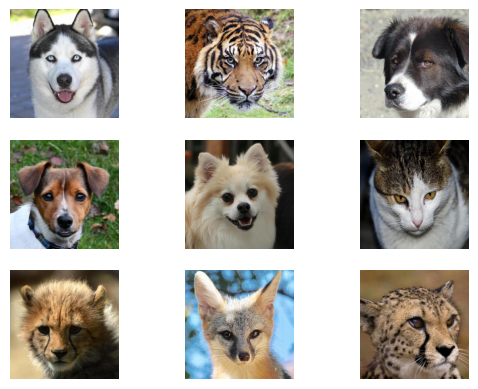

In [82]:
from PIL import Image

n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):

    image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

In [84]:
LR = 1e-4
BACTH_SIZE = 16
EPOCHS =10

In [85]:
train_loader = DataLoader(train_dataset,batch_size=BACTH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BACTH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BACTH_SIZE,shuffle=True)

In [86]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linera = nn.Linear(128*16*16, 128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))


  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (32, 128, 128)
    x = self.pooling(x)# -> Outputs: (32, 64, 64)
    x = self.relu(x)
    x = self.conv2(x) # -> Outputs: (64, 64, 64)
    x = self.pooling(x) # -> Outputs: (64, 32, 32)
    x = self.relu(x)
    x = self.conv3(x) # -> Outputs: (128, 32, 32)
    x = self.pooling(x) # -> Outputs: (128, 16, 16)
    x = self.relu(x)
    x = self.flatten(x)
    x = self.linera(x) # Call the correct layer name here (linear -> linera)
    x = self.output(x)

    return x

model = Net().to(device)

In [87]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [91]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)


Epoch 1/10, Train Loss: 2.0832 Train Accuracy 90.3208
              Validation Loss: 0.1689 Validation Accuracy: 94.2963
Epoch 2/10, Train Loss: 1.1592 Train Accuracy 94.8853
              Validation Loss: 0.1349 Validation Accuracy: 95.2263
Epoch 3/10, Train Loss: 0.7821 Train Accuracy 96.629
              Validation Loss: 0.1196 Validation Accuracy: 95.6603
Epoch 4/10, Train Loss: 0.5416 Train Accuracy 97.6829
              Validation Loss: 0.1513 Validation Accuracy: 94.6683
Epoch 5/10, Train Loss: 0.3622 Train Accuracy 98.4656
              Validation Loss: 0.1302 Validation Accuracy: 96.2802
Epoch 6/10, Train Loss: 0.2847 Train Accuracy 98.7911
              Validation Loss: 0.0982 Validation Accuracy: 96.6522
Epoch 7/10, Train Loss: 0.2097 Train Accuracy 99.1476
              Validation Loss: 0.0954 Validation Accuracy: 97.1482
Epoch 8/10, Train Loss: 0.1499 Train Accuracy 99.3645
              Validation Loss: 0.1122 Validation Accuracy: 96.4662
Epoch 9/10, Train Loss: 0.1013 Tr

In [92]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 95.8462 and Loss is 0.0148


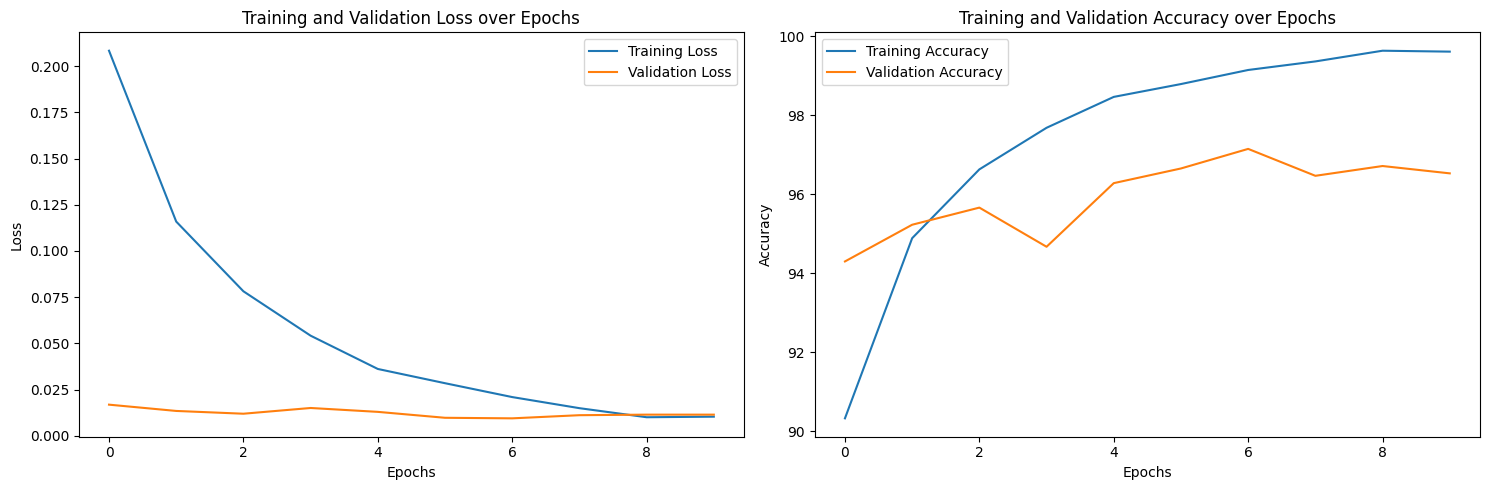

In [93]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

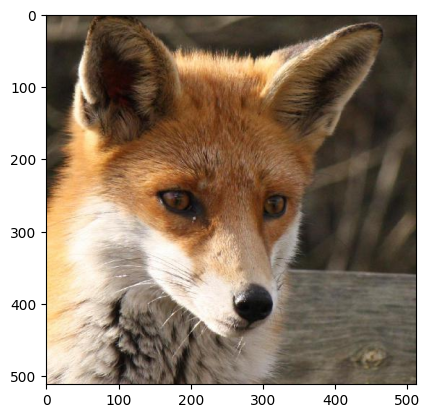


Prediction: 

['wild']


In [97]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = data_transforms(image).to(device) # Use data_transforms instead of transform

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

# Assuming you've uploaded the image to /content/
image_path = "/content/animal-faces/afhq/train/wild/flickr_wild_000002.jpg"

## Visualize the image
image = Image.open(image_path)
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
print(predict_image(image_path)) # Print the prediction
